In [0]:
# -*- coding: utf-8 -*-

# Index: 1 : Done
from google.colab import drive
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [0]:
class Constants:
    cuda = False
    batch_size = 256
    epochs = 500
    reg = 0.00005
    linearD = 512
    learning_rate = 0.0005
    MODEL_PATH = '/content/drive/My Drive/nla_models/'
    DATA_PATH = '/content/drive/My Drive/nla_data/'
    datasets = ['SQuAD', 'WikiMovies']
    features = ['sum_span_score', 'sum_doc_score', 'doc_score', 'span_score', 'min_doc_score', 'max_doc_score', 'avg_doc_score',
                'max_span_score', 'min_span_score', 'avg_span_score', 'first_occ', 'num_occ', 'context_len', 'question_len']

    preprocess = np.log
    normalization_scheme = "normal"
    maximum_depth = 2
    maximum_depth_per_question = 2
    validation_set_split = 0.9
    early_stopping = 8

In [0]:
def bootstrap():
    try:
        drive.mount('/content/drive', force_remount=False)
        if not os.path.exists(Constants.DATA_PATH):
            raise Exception
        print("Data Path exists:" + str(Constants.DATA_PATH))
        if not os.path.exists(Constants.MODEL_PATH):
            raise Exception
        print("Model Path exists:" + str(Constants.MODEL_PATH))
    except:
        print("FATAL: Something went terribly wrong!, Exiting...")
        exit(1)

In [0]:
bootstrap()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Data Path exists:/content/drive/My Drive/nla_data/
Model Path exists:/content/drive/My Drive/nla_models/


In [0]:

class DatasetHelper(object):
    supported_datasets = ["SQuAD", "WikiMovies"]

    dataset_train_format = {"SQuAD": "SQuAD-v1.1-train-default-pipeline.preds-part-",
                            "WikiMovies": "WikiMovies-train-default-pipeline.preds-part-"}

    dataset_train_count = {"SQuAD": 88, "WikiMovies": 97}

    dataset_test_format = {"SQuAD": "SQuAD-v1.1-dev-default-pipeline.preds-part-",
                           "WikiMovies": "WikiMovies-test-default-pipeline.preds-part-"}

    dataset_test_count = {"SQuAD": 11, "WikiMovies": 10}

    def __init__(self, datasets=["SQuAD"]):
        self.datasets = []
        self.train_files = None
        self.test_files = None
        for dataset in datasets:
            if dataset not in DatasetHelper.dataset_train_format:
                print("WARNING: " + dataset +
                      " is not supported, ignoring this dataset")
                continue
            self.datasets.append(dataset)

    @staticmethod
    def _get_dataset_train_file(dataset, number):
        return Constants.DATA_PATH + DatasetHelper.dataset_train_format[dataset]+str(number)

    @staticmethod
    def _get_dataset_test_file(dataset, number):
        return Constants.DATA_PATH + DatasetHelper.dataset_test_format[dataset]+str(number)

    def get_train_files(self):
        if self.train_files is not None:
            return self.train_files

        self.train_files = []

        for dataset in self.datasets:
            new_train_files = []
            for i in range(DatasetHelper.dataset_train_count[dataset]):
                new_train_files.append(
                    DatasetHelper._get_dataset_train_file(dataset, i))
            self.train_files.append(new_train_files)

        return self.train_files

    def get_test_files(self):

        if self.test_files is not None:
            return self.test_files

        self.test_files = []

        for dataset in self.datasets:
            new_test_files = []
            for i in range(DatasetHelper.dataset_test_count[dataset]):
                new_test_files.append(
                    DatasetHelper._get_dataset_test_file(dataset, i))
            self.test_files.append(new_test_files)

        return self.test_files

    @staticmethod
    def generate_pairs(data):
        training_pairs = []
        new_pairs = 0
        limit = len(data) - 1 if len(data) - \
            1 < Constants.maximum_depth else Constants.maximum_depth

        for i in range(limit):
            if data[i]['target'] == data[i + 1]['target']:
                continue
            new_pairs += 1
            x = (data[i], data[i + 1]
                 ) if data[i]['target'] == 1 else (data[i + 1], data[i])
            training_pairs.append(x)
            if new_pairs >= Constants.maximum_depth_per_question:
                break

        return training_pairs

    def get_train_datsets_count(self):
        return len(self.train_files)
    

    def generate_subsample(self, feature_descriptors):
        subsample, subsample_valid = [],  []
        features = copy.deepcopy(feature_descriptors)
        values = [[]] * len(features)
        min_length = 1000000000000
        for file_names in self.train_files:
            new_sample, new_sample_valid = [], []
            for file_name in file_names:
                if not os.path.exists(file_name):
                    print(
                        "WARNING: File missing, ignoring the file: {}".format(file_name))
                    continue
                f = open(file_name, 'r')
                for line in f:
                    answers = json.loads(line)
                    if len(answers) < 1:
                        continue

                    for answer_candiate in answers:
                        for i, feature in enumerate(features):
                            value = answer_candiate[feature['name']]
                            values[i].append(value)

                    subsampled = DatasetHelper.generate_pairs(answers)

                    if len(subsampled) == 0:
                        continue

                    if random.random() < Constants.validation_set_split:
                        new_sample.extend(subsampled)
                    else:
                        new_sample_valid.extend(subsampled)
                f.close()

            subsample.append(new_sample)
            subsample_valid.append(new_sample_valid)
            min_length = len(new_sample_valid) if len(
                new_sample_valid) < min_length else min_length

        train, valid = [], []

        for i in range(self.get_train_datsets_count()):
            train.extend(subsample[i])
            train_split, valid_split = subsample[i][
                min_length:], subsample_valid[i][0:min_length]
            train.extend(train_split)
            valid.extend(valid_split)

        for i, feature in enumerate(features):
            feature['mean'] = np.mean(values[i])
            feature['max'] = np.max(values[i])
            feature['min'] = np.min(values[i])
            feature['std'] = np.std(values[i])
            # FeaturesHelper.plot_features(values[i])

        return train, valid, features

    def generate_test_data(self, file_names):
        self.test_data = []
        for file_name in file_names:
            if not os.path.exists(file_name):
                print("WARNING: File missing, ignoring the file: {}".format(file_name))
                continue
            f = open(file_name, 'r')
            for line in f:
                self.test_data.append(json.loads(line))

    def build_test_dataset(self, features):
        x, y, types, questions, answers = [], [], [], [], []
        for data in self.test_data:
            tx, ty, ans, i = [], [], [], 0
            for d in data:
                ok, qtype = FeaturesHelper.get_feature_vector(d, features,True)
                types.append(qtype)
                tx.append(ok)
                ty.append(d['target'])
                ans.append(d['context'])
                if i == 0:
                  questions.append(d['question'])
                  i += 1
            x.append(tx)
            y.append(ty)
            answers.append(ans)
        return x, y, types, questions, answers

In [0]:
class FeaturesHelper(object):
    NER_DICT = {'location': 0, 'person': 1, 'organization': 2, 'money': 3, 'percent': 4, 'date': 5, 'time': 6, 'o': 7,
                'set': 8, 'duration': 9, 'number': 10, 'ordinal': 11, 'misc': 12}

    POS_DICT = {'NNP': 0, 'JJ': 1, 'NN': 2, 'IN': 3, ',': 4, 'CC': 5, 'DT': 6, 'VBG': 7, 'VB': 8, 'NNS': 9, 'POS': 10,
                'VBZ': 11, 'RB': 12, 'TO': 13, 'FW': 14, 'PRP$': 15, 'CD': 16, 'VBN': 17, 'NNPS': 18, 'JJR': 19, 'VBP': 20,
                ':': 21, 'VBD': 22, 'PRP': 23, '#': 24, 'JJS': 25, '$': 26, 'WRB': 27, '-LRB-': 28, '-RRB-': 29, '.': 30,
                '``': 31, "''": 32, 'PDT': 33, 'MD': 34, 'WP': 35, 'RP': 36, 'WDT': 37, 'EX': 38, 'UH': 39, 'SYM': 40,
                'LS': 41, 'RBS': 42, 'RBR': 43, 'WP$': 44}

    Q_TYPE = {'what was': 0, 'what is': 1, 'what': 2, 'in what': 3, 'in which': 4, 'in': 5,
              'when': 6, 'where': 7, 'who': 8, 'why': 9, 'which': 10, 'is': 11, 'other': 12}

    def __init__(self, features, preprocess, normalization_scheme):
        self.feature_descriptors = []
        for feature_name in features:
            # if 'span' not in feature_name:
            self.feature_descriptors.append(
                 {"name": feature_name, "normalization_scheme": normalization_scheme, "preprocess": preprocess})

    def get_features(self):
        return self.feature_descriptors

    @staticmethod
    def calculate_jaccard_index(words_list1, words_list2):
        a = set(words_list1)
        b = set(words_list2)
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    
    @staticmethod
    def plot_features(vals):
        vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
        vals = np.round_(vals, decimals = 5)
        req = {}
        for i in vals:
          if i not in req:
            req[i] = 0
          req[i] += 1
        # plt.figure(figsize=(12, 4))
        plt.bar(req.keys(), req.values(), 1, color='g')
        plt.show()


    @staticmethod
    def get_ner_pos_vector(data, name):
        provider = FeaturesHelper.NER_DICT if name == 'ner' else FeaturesHelper.POS_DICT
        vec = np.zeros(len(provider))
        for value in data['span_'+name]:
            v = value.lower() if name == 'ner' else value
            vec[provider[v]] = 1
        return vec

    @staticmethod
    def get_qtype_vector(data):
        vec = np.zeros(len(FeaturesHelper.Q_TYPE))
        qwords = data['question'].lower().split(' ')
        other = True
        typp = "Other"
        if qwords[0] in FeaturesHelper.Q_TYPE:
            vec[FeaturesHelper.Q_TYPE[qwords[0]]] = 1
            other = False
            typp = qwords[0]
        if len(qwords) > 1:
          double_word = qwords[0] + ' ' + qwords[1]
          if double_word in FeaturesHelper.Q_TYPE:
              vec[FeaturesHelper.Q_TYPE[double_word]] = 1
              other = False
              typp += (" , " + double_word)
        if other:
            vec[FeaturesHelper.Q_TYPE['other']] = 1
        return vec, typp

    @staticmethod
    def do_normalization(data, feature):
        value = data[feature["name"]]
        # return value
        if 'preprocess' in feature:
            value = feature['preprocess'](value)
        if 'normalization_scheme' not in feature:
            return value
        return value
        if feature['normalization_scheme'] == 'normal':
            return (value - feature['mean']) / feature['std']
        if feature['normalization_scheme'] == 'minmax':
            return (value - feature['min']) / (feature['max'] - feature['min'])

    @staticmethod
    def get_feature_vector(data, features, forTest=False):
        ner = FeaturesHelper.get_ner_pos_vector(data, 'ner')
        pos = FeaturesHelper.get_ner_pos_vector(data, 'pos')
        qtype,typp = FeaturesHelper.get_qtype_vector(data)

        normalized_features = np.zeros(len(features) + 1)
        for i, feature in enumerate(features):
            normalized_features[i] = FeaturesHelper.do_normalization(
                data, feature)

        para_tokens = data['context']['tokens']
        question_tokens = data['question_tokens']
        normalized_features[-1] = FeaturesHelper.calculate_jaccard_index(
            para_tokens, question_tokens)

        all_features = (ner, pos, qtype, normalized_features) 
        if forTest:
          return torch.from_numpy(np.concatenate(all_features, axis=-1)).float(), typp  
        return torch.from_numpy(np.concatenate(all_features, axis=-1)).float()


In [0]:
dataset_helper = DatasetHelper(Constants.datasets)
train_files = dataset_helper.get_train_files()
test_files = dataset_helper.get_test_files()

In [0]:
features_helper = FeaturesHelper(
    Constants.features, Constants.preprocess, Constants.normalization_scheme)

In [0]:
train_data, valid_data, features = dataset_helper.generate_subsample(
    features_helper.get_features())

In [0]:
print(len(train_data))
stop, total = 0, 0
for ques in train_data:
  for ans in ques:
    if ans['num_occ'] > 1:
      stop = 1
      for i in ans:
        if i != 'context':
          print(i, ":",ans[i])
      for i in ans['context']:
        print(i, ":", ans['context'][i])
  if stop == 1:
    break
print(stop, total)
print(len(valid_data))

178380
qid : 6
doc_id : Notre Dame Fighting Irish football rivalries
span : twice
doc_score : 348.2196698942894
span_score : 270.06732177734375
context_len : 235
question_len : 10
question : How often is Notre Dame 's the Juggler published ?
first_occ : 3
num_occ : 4
sum_doc_score : 1260.2189824220168
sum_span_score : 528.9819183349609
avg_span_score : 132.24547958374023
max_span_score : 270.06732177734375
min_span_score : 16.562332153320312
avg_doc_score : 315.0547456055042
max_doc_score : 348.2196698942894
min_doc_score : 295.7261535188909
question_tokens : ['How', 'often', 'is', 'Notre', 'Dame', "'s", 'the', 'Juggler', 'published', '?']
span_tokens : ['twice']
span_ner : ['O']
span_pos : ['RB']
target : 1
text : The Fighting Irish and Nebraska Cornhuskers first met in 1915 and played each other annually through 1925. During the years of Notre Dame's famed Four Horsemen backfield from 1922–24, the Fighting Irish compiled a record of 27–2–1, with their only losses coming to Nebraska i

In [0]:
class Evaluator(object):
    def __init__(self, X, y, name,types, questions, answers):
        self.X, self.y = X, y
        self.name = name
        self.n = len(self.y)
        self.base, self.curr, self.top = 0, 0, 0
        self.types = types
        self.total_dist, self.wrong_dist = {}, {}
        self.questions = questions
        self.answers = answers

    def initial_params(self):
        X, y, questions, answers = [], [], [], []
        with torch.no_grad():
            for i, x in enumerate(self.X):
                inputs = []
                solvable = False
                for j, candidate in enumerate(x):
                    if self.y[i][j] == 1:
                        solvable = True
                self.base += int(self.y[i][0])
                if not solvable:
                    continue
                X.append(x)
                questions.append(self.questions[i])
                answers.append(self.answers[i])
                y.append(self.y[i])
                self.top += 1
                if self.types[i] not in self.total_dist:
                  self.total_dist[self.types[i]] = 0
                  self.wrong_dist[self.types[i]] = 0
                self.total_dist[self.types[i]] += 1
        self.X, self.y = X, y
        self.questions, self.answers = questions, answers
        self.base = self.base / self.n
        self.top = self.top / self.n

    def evaluate(self, model):
        wrong, correct = [], []
        self.wrong_dist.clear()
        with torch.no_grad():
            for i, x in enumerate(self.X):
                inputs = []
                for j, candidate in enumerate(x):
                    inputs.append(candidate)
                scores = model.predict(torch.stack(inputs))
                j = np.argmax(scores[0:10])
                self.curr += int(self.y[i][j])        
                if int(self.y[i][j]) == 0:
                    if self.types[i] not in self.wrong_dist:
                      self.wrong_dist[self.types[i]] = 0
                    self.wrong_dist[self.types[i]] += 1
                    wrong.append([i, j])
                else:
                  correct.append([i, j])

        self.curr = self.curr / self.n
        return correct, wrong

In [0]:
evaluators = []
for i, dataset in enumerate(test_files):
    dataset_helper.generate_test_data(dataset)
    x, y, types, questions, answers = dataset_helper.build_test_dataset(features)
    evaluators.append(Evaluator(x, y, i, types, questions, answers))

In [0]:
class PairwiseRankingDataSet():

    def __init__(self, subsampled, normalizers):
        self.Xa, self.Xb, self.y = [], [], []
        for xa, xb in subsampled:
            if random.randint(1, 2) == 1:
                self.Xa.append((FeaturesHelper.get_feature_vector(xa, normalizers)))
                self.Xb.append((FeaturesHelper.get_feature_vector(xb, normalizers)))
                self.y.append(torch.tensor(float(xa['target'])))
            else:
                self.Xa.append((FeaturesHelper.get_feature_vector(xb, normalizers)))
                self.Xb.append((FeaturesHelper.get_feature_vector(xa, normalizers)))
                self.y.append(torch.tensor(float(xb['target'])))
        self.num_feat = len(self.Xa[0])

    def __getitem__(self, index):
        return self.Xa[index], self.Xb[index], self.y[index]

    def __len__(self):
        return len(self.y)

In [0]:
# Index: 14 : Done
train_dataset = PairwiseRankingDataSet(train_data, features)
valid_dataset = PairwiseRankingDataSet(valid_data, features)

# Test: Need not run
print(len(train_dataset), len(valid_dataset))

178380 9472


In [0]:
def batchify_pair(batch):
    xa = torch.stack([ex[0] for ex in batch])
    xb = torch.stack([ex[1] for ex in batch])
    y = torch.stack([ex[2] for ex in batch])
    return xa, xb, y

# Index: 16 : Done


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=Constants.batch_size,
    sampler=torch.utils.data.sampler.RandomSampler(train_dataset),
    pin_memory=Constants.cuda,
    collate_fn=batchify_pair
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=Constants.batch_size,
    sampler=torch.utils.data.sampler.RandomSampler(valid_dataset),
    pin_memory=Constants.cuda,
    collate_fn=batchify_pair
)

In [0]:
class RankNetModel(nn.Module):

    def __init__(self,  feat_size):
        super(RankNetModel, self).__init__()

        self.linear = nn.Linear(feat_size, Constants.linearD)
        self.activ2 = nn.ReLU()
        self.linear2 = nn.Linear(int(Constants.linearD), 1)

        self.output_sig = nn.Sigmoid()

    def forward(self, inputl):
        return self.output_sig(self._forward_pass(inputl))

    def forward_pairwise(self, input1, input2):
        s1 = self._forward_pass(input1)
        s2 = self._forward_pass(input2)

        out = self.output_sig(s1 - s2)
        # out = self.output_sig(s1)
        return out

    def _forward_pass(self, input_sample):
        out = self.linear(input_sample)
        out = self.activ2(out)
        out = self.linear2(out)
        return out

    def predict(self, input):
        return self._forward_pass(input)

# Index: 18 : Done


class RankerNet(object):

    def __init__(self, num_feat):
        self.network = RankNetModel(num_feat)
        self.optimizer = optim.Adam(self.network.parameters(), lr=Constants.learning_rate)
        self.loss_func = nn.functional.mse_loss
        self.loss_func_single = nn.functional.mse_loss

    def predict(self, input):
        self.network.eval()
        input = Variable(input)
        scores = self.network.predict(input)
        return scores.data.cpu()

    def eval_pairwise(self, input_l, input_r, targets):
        self.network.eval()
        with torch.no_grad():
            targets = Variable(targets)
            input_l = Variable(input_l)
            input_r = Variable(input_r)

            y_pred = self.network.forward_pairwise(input_l, input_r)

            loss = self.loss_func_single(y_pred[:, 0], targets)
        return loss.item()

    def update_pairwise(self, input_l, input_r, targets):
        self.network.train()

        self.network.zero_grad()
        targets = Variable(targets)
        input_l = Variable(input_l)
        input_r = Variable(input_r)

        y_pred = self.network.forward_pairwise(input_l, input_r)

        loss = self.loss_func_single(y_pred[:, 0], targets)
        l2_reg = None

        for W in self.network.parameters():
            if l2_reg is None:
                l2_reg = W.norm(2)
            else:
                l2_reg = l2_reg + W.norm(2)

        loss = loss + Constants.reg * l2_reg

        loss.backward()
        self.optimizer.step()
        return loss.item()

    def save(self, path):
        torch.save(self.network, path)
        pass

    def load(self, path):
        self.network = torch.load(path)
        pass


def calculate_loss(data_loader, model , typ):
    loss = []
    for data in data_loader:
        inl, inr, target = data
        l = model.eval_pairwise(inl, inr, target) if typ == "val" else model.update_pairwise(inl, inr, target)
        loss.append(l)
    return np.mean(loss)

In [0]:

def plot(total, wrong):
  wrong_percent = {}
  for i in wrong:
    print(total[i], wrong[i], i)
    wrong_percent[i] = wrong[i] / total[i]
  plt.figure(figsize=(12, 4))
  plt.bar(wrong_percent.keys(), wrong_percent.values(), 0.5, color='g')
  plt.show()
  return


0.011921227944710623
1103 637 which
214 129 where
2507 1304 what
1116 562 what , what was
325 138 what , what is
2196 961 who
2737 1128 Other
189 118 in , in what
976 584 when
113 51 in


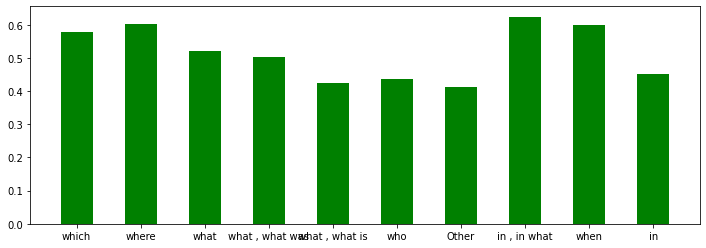

0.027735017149843364
11942 5736 what
992 455 Other


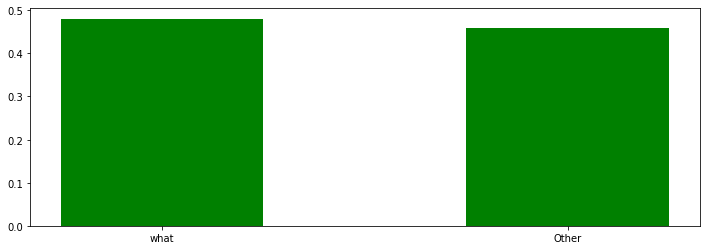

In [0]:
initiallywrong = []
model = RankerNet(train_dataset.num_feat)

for evaluator in evaluators:
    evaluator.initial_params()

for evaluator in evaluators:
    _, wrongans = evaluator.evaluate(model)
    print(evaluator.curr)
    initiallywrong.append(wrongans)
    plot(evaluator.total_dist, evaluator.wrong_dist)


In [0]:
print(train_dataset.num_feat)
# Index: 20 : Done
model_save_path = Constants.MODEL_PATH + 'dry_run' + '.out'

best_val_loss = float('inf')
best_val_iteration = 0

for i in range(Constants.epochs):
    print('EPOCH '+str(i))
    train_loss = calculate_loss(train_loader, model,'train')
    val_loss = calculate_loss(valid_loader, model,'val')

    print('Train loss '+ str(train_loss))
    print('Validation loss '+str(val_loss))

    if best_val_loss > val_loss:
        print('Got a new best model, SAVING!!')
        model.save(model_save_path)
        best_val_loss = val_loss
        best_val_iteration = 0

    best_val_iteration += 1

    if best_val_iteration > Constants.early_stopping:
        print("doing early stopping")
        break

model.load(model_save_path)



86
EPOCH 0
Train loss 0.12059119218690495
Validation loss 0.11416456667152611
Got a new best model, SAVING!!
EPOCH 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train loss 0.10988466444838167
Validation loss 0.11042052889997894
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.10657993173881446
Validation loss 0.10734419544806352
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.10495830233204827
Validation loss 0.10701194204188683
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.10394803474161513
Validation loss 0.10508979071636458
Got a new best model, SAVING!!
EPOCH 5
Train loss 0.10279137143060843
Validation loss 0.10391966092425424
Got a new best model, SAVING!!
EPOCH 6
Train loss 0.10179323180334127
Validation loss 0.10359527231068225
Got a new best model, SAVING!!
EPOCH 7
Train loss 0.10101254368828906
Validation loss 0.10294074927632874
Got a new best model, SAVING!!
EPOCH 8
Train loss 0.10016469714075456
Validation loss 0.1022721440405459
Got a new best model, SAVING!!
EPOCH 9
Train loss 0.09937672729642695
Validation loss 0.10210169972600164
Got a new best model, SAVING!!
EPOCH 10
Train loss 0.09879554035289044
Validation loss

0.3459173032536774


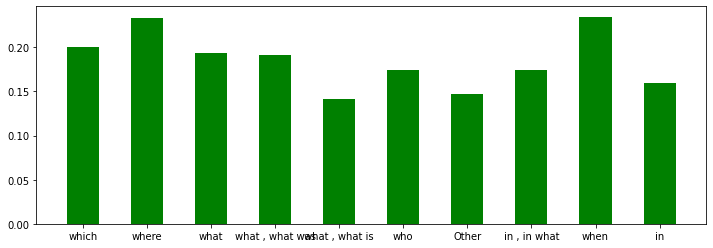

0.43091146449977097


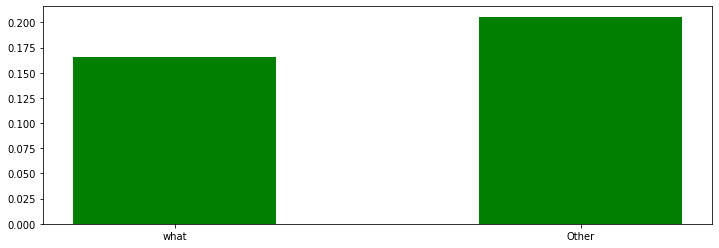

In [0]:
curr_wrong, curr_correct= [], []
for i, evaluator_ in enumerate(evaluators):
    correct, wrong = evaluator_.evaluate(model)
    curr_wrong.append(wrong)
    curr_correct.append(correct)
    print(evaluator_.curr)
    plot(evaluator_.total_dist, evaluator_.wrong_dist)


In [0]:
for i, wrong_set in enumerate(curr_correct):
  curr = 0
  for wrong in wrong_set:
    print(evaluators[i].questions[wrong[0]])
    x = evaluators[i].answers[wrong[0]][wrong[1]]
    if x['start'] < len(x['tokens']):
      for k in range(x['start'], min(x['end'], len(x['tokens']))):
        print(x['tokens'][k], end=" ")
    else:
      print("No answer", end = " ")
    print()
    if curr > 20: 
      break
    curr += 1


Which NFL team represented the AFC at Super Bowl 50 ?
No answer 
Which NFL team won Super Bowl 50 ?
No answer 
What is the AFC short for ?
No answer 
If Roman numerals were used , what would Super Bowl 50 have been called ?
No answer 
What year was Super Bowl 50 ?
No answer 
Which team won Super Bowl 50 .
No answer 
Where was Super Bowl 50 held ?
No answer 
The name of the NFL championship game is ?
No answer 
Which Carolina Panthers player was named Most Valuable Player ?
Game . They joined the Patriots , Dallas Cowboys , 
How many appearances have the Denver Broncos made in the Super Bowl ?
No answer 
What year was the Carolina Panthers franchise founded ?
No answer 
How many teams have been in the Super Bowl eight times ?
No answer 
Who did Denver beat in the AFC championship ?
No answer 
What year did the Carolina Panthers form ?
No answer 
Which Denver linebacker was named Super Bowl MVP ?
No answer 
How many solo tackles did Von Miller make at Super Bowl 50 ?
No answer 
How many 

In [0]:
for i, wrong_set in enumerate(curr_wrong):
  curr = 0
  for wrong in wrong_set:
    print(evaluators[i].questions[wrong[0]])
    x = evaluators[i].answers[wrong[0]][wrong[1]]
    if x['start'] < len(x['tokens']):
      for k in range(x['start'], min(x['end'], len(x['tokens']))):
        print(x['tokens'][k], end=" ")
    else:
      print("No answer", end = " ")
    print()
    if curr > 20: 
      break
    curr += 1


Where did Super Bowl 50 take place ?
the Astrodome several years prior to Super Bowl VIII . The Orange Bowl was the only AFL stadium to host a Super Bowl and the only stadium to host consecutive Super Bowls , hosting Super Bowls II and III . 
Which NFL team won Super Bowl 50 ?
. The Colts scored 3 TDs in 2:10 . 
What color was used to emphasize the 50th anniversary of the Super Bowl ?

Who won Super Bowl 50 ?

Super Bowl 50 decided the NFL champion for what season ?

What year did the Denver Broncos secure a Super Bowl title for the third time ?

What month , day and year did Super Bowl 50 take place ?
have a Super Bowl 
What team was the AFC champion ?

Who won Super Bowl 50 ?

Super Bowl 50 determined the NFL champion for what season ?
season record . 
What 2015 NFL team one the AFC playoff ?

What team did the Panthers defeat ?

Who did the Panthers beat in the NFC Championship Game ?

Who lost to the Broncos in the AFC Championship ?

Who were the defending Super Bowl champions ?

How many teams have been in the Super Bowl eight times ?

Who was this season 's NFL MVP ?

What was the win/loss ratio in 2015 for the Carolina Panthers during their regular season ?
an offensive touchdown 
How many teams have played in the Super Bowl eight times ?

Which team did not get a chance to defend their Super Bowl XLIX win in Super Bowl 50 ?

Who is the quarterback for the Panthers ?

Who did Denver beat in the 2015 AFC Championship game ?

what films did Michelle Trachtenberg star in ?
Book Union collected a 
Brendan Gleeson appears in which movies ?

what films does Brigitte Nielsen appear in ?

what films does William Atherton appear in ?

Ruggero Raimondi appears in which movies ?
Angela Gheorghiu 
what films did Robert Strauss act in ?

what films did Aleksandr Gordon act in ?

what movies was Chris O'Donnell an actor in ?

what films did Melvin Van Peebles star in ?

what does Tannishtha Chatterjee appear in ?
performance of the year . 
what movies was Michael Tully an actor in ?

what movies was Dan Petronijevic an actor in ?

what films did Piolo Pascual star in ?
as Patricia Montecillo , an 
what does Nell Cattrysse star in ?

what does Sharon Gans act in ?
benefits for Lesh 's 
what does Beatrice Lillie act in ?

what movies did Nicole Grimaudo act in ?

what films did Agnes Ayres act in ?
Shelbyville , Illinois . He , 
what films did Audra Lindley act in ?

what films did Tamara Toumanova star in ?

what films does Ralf Harolde appear in ?

what movies did Sophie Rois star in ?
who stumbled upon the bean was called `` 

**WITH ALL FEATURES**
86
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.29820245979186377
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3840434083601286
EPOCH 0
Train loss 0.23822287296362019
Validation loss 0.37109774351119995
Got a new best model, SAVING!!
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
EPOCH 1
Train loss 0.6151828748814879
Validation loss 0.3840262434772543
EPOCH 2
Train loss 0.25392582552115806
Validation loss 0.21616457483252963
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.20924984502775304
Validation loss 0.2164179582048107
EPOCH 4
Train loss 0.20859487007274818
Validation loss 0.2183562541330183
EPOCH 5
Train loss 0.20809646052053898
Validation loss 0.2162805433208878
EPOCH 6
Train loss 0.20799602941211542
Validation loss 0.21351534208735903
Got a new best model, SAVING!!
EPOCH 7
Train loss 0.20671448021999245
Validation loss 0.21003613983457153
Got a new best model, SAVING!!
EPOCH 8
Train loss 0.2508569326097191
Validation loss 0.37065121048205607
EPOCH 9
Train loss 0.2019098688114184
Validation loss 0.2032722313259099
Got a new best model, SAVING!!
EPOCH 10
Train loss 0.2017279878280023
Validation loss 0.20859725612240868
EPOCH 11
Train loss 0.20107396443684897
Validation loss 0.20573178960664854
EPOCH 12
Train loss 0.1999712948059831
Validation loss 0.20577842923435005
EPOCH 13
Train loss 0.19771120666349054
Validation loss 0.2065236177798864
EPOCH 14
Train loss 0.19552490391231572
Validation loss 0.20906037253302498
EPOCH 15
Train loss 0.20531005557301388
Validation loss 0.21352773300699285
EPOCH 16
Train loss 0.2073136563379536
Validation loss 0.21288699113033913
EPOCH 17
Train loss 0.20249303354640547
Validation loss 0.20820266894392064
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.3039735099337748
fraction still correct = 0.9808449938867002
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3954983922829582
fraction still correct = 0.9764315352697095

***WITHOUT sum features ***
84
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.2998107852412488
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3853496784565916
EPOCH 0
Train loss 0.23775713302023793
Validation loss 0.20308961405565865
Got a new best model, SAVING!!
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
EPOCH 1
Train loss 0.23107947957241673
Validation loss 0.3918383897919404
EPOCH 2
Train loss 0.2673755784294215
Validation loss 0.202741534694245
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.21194925108903098
Validation loss 0.21268430430638163
EPOCH 4
Train loss 0.21457604001993422
Validation loss 0.21528208451835731
EPOCH 5
Train loss 0.3315274129439702
Validation loss 0.37361971563414526
EPOCH 6
Train loss 0.32095772106114817
Validation loss 0.20005381342611814
Got a new best model, SAVING!!
EPOCH 7
Train loss 0.33187506596247357
Validation loss 0.39384917209022924
EPOCH 8
Train loss 0.38340928482598274
Validation loss 0.37920785499246495
EPOCH 9
Train loss 0.3807869867860586
Validation loss 0.38309293436376674
EPOCH 10
Train loss 0.35556077661699265
Validation loss 0.2130378857254982
EPOCH 11
Train loss 0.20053864762872115
Validation loss 0.19908501443110013
Got a new best model, SAVING!!
EPOCH 12
Train loss 0.202927158727985
Validation loss 0.20560270469439657
EPOCH 13
Train loss 0.2054754189247715
Validation loss 0.20454096519633344
EPOCH 14
Train loss 0.20513274978803492
Validation loss 0.2067141097627188
EPOCH 15
Train loss 0.20487714361870427
Validation loss 0.20399681910088188
EPOCH 16
Train loss 0.20502729801696606
Validation loss 0.20045368530248342
EPOCH 17
Train loss 0.20795371308494573
Validation loss 0.2116632041962523
EPOCH 18
Train loss 0.20648560625897056
Validation loss 0.216105643855898
EPOCH 19
Train loss 0.21348697729622837
Validation loss 0.21034296994146548
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30274361400189215
fraction still correct = 0.9940338983050847
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.39439308681672025
fraction still correct = 0.988422097254383

**WIHTOUT 'min' features**

84
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.040018921475875116
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.10540594855305466
EPOCH 0
Train loss 0.22070005709571497
Validation loss 0.2030413577685485
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.19960331857204439
Validation loss 0.2028731260750745
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.20037322318979672
Validation loss 0.20083977966695218
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.2016673558311803
Validation loss 0.19276030683839643
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.22282130603279388
Validation loss 0.20602257267848864
EPOCH 5
Train loss 0.19778986166630472
Validation loss 0.20298635959625244
EPOCH 6
Train loss 0.19987941895212447
Validation loss 0.1988240850938333
EPOCH 7
Train loss 0.20090709655412606
Validation loss 0.20213932805770152
EPOCH 8
Train loss 0.2036150158622435
Validation loss 0.20175692076618607
EPOCH 9
Train loss 0.20020452012973172
Validation loss 0.20190237583340825
EPOCH 10
Train loss 0.19962286416973388
Validation loss 0.202161137316678
EPOCH 11
Train loss 0.20094354097332273
Validation loss 0.20239267035110578
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30558183538315986
fraction still correct = 0.9817538126361656
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.39509646302250806
fraction still correct = 0.9627606752730884

**WITHOUT 'max' features**

84
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30056764427625354
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.38444533762057875
EPOCH 0
Train loss 0.20069134602574018
Validation loss 0.20619386072094376
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.3091058416617634
Validation loss 0.20153262043321454
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.29161193123604984
Validation loss 0.20063699218066963
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.26131419253596944
Validation loss 0.37075504660606384
EPOCH 4
Train loss 0.3779742037156933
Validation loss 0.37116027119997386
EPOCH 5
Train loss 0.311137635527675
Validation loss 0.21032937475152919
EPOCH 6
Train loss 0.20186208239769868
Validation loss 0.20154883088292302
EPOCH 7
Train loss 0.19944580838639278
Validation loss 0.20468653496858236
EPOCH 8
Train loss 0.19974709925559325
Validation loss 0.20249560153162158
EPOCH 9
Train loss 0.19888881944055886
Validation loss 0.20076756743160454
EPOCH 10
Train loss 0.20337621225070818
Validation loss 0.21063997737459234
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30454115421002836
fraction still correct = 0.9883040935672515
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3933882636655949
fraction still correct = 0.9847984137475215

**WITHOUT 'avg' features**

84
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.01021759697256386
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.04551848874598071
EPOCH 0
Train loss 0.2592987297262464
Validation loss 0.2236709776851866
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.2052530804702214
Validation loss 0.20704853990011746
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.2404541619547776
Validation loss 0.20200427662995127
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.32455499131764687
Validation loss 0.36875537037849426
EPOCH 4
Train loss 0.3247411749618394
Validation loss 0.36785782873630524
EPOCH 5
Train loss 0.4089677958403315
Validation loss 0.3672294177942806
EPOCH 6
Train loss 0.3604841136506626
Validation loss 0.3659812692138884
EPOCH 7
Train loss 0.30743498338120323
Validation loss 0.20130400442414814
Got a new best model, SAVING!!
EPOCH 8
Train loss 0.19661333190543312
Validation loss 0.20415200789769491
EPOCH 9
Train loss 0.1990791424896036
Validation loss 0.2037591685851415
EPOCH 10
Train loss 0.19889025295419352
Validation loss 0.20312409020132488
EPOCH 11
Train loss 0.1975596172256129
Validation loss 0.19923283201124933
Got a new best model, SAVING!!
EPOCH 12
Train loss 0.2602915121827807
Validation loss 0.3773460164666176
EPOCH 13
Train loss 0.36550438250814166
Validation loss 0.3622078870733579
EPOCH 14
Train loss 0.35093347709093775
Validation loss 0.36315470354424584
EPOCH 15
Train loss 0.2016026651327099
Validation loss 0.1967666633427143
Got a new best model, SAVING!!
EPOCH 16
Train loss 0.5148252396924156
Validation loss 0.6791479802793927
EPOCH 17
Train loss 0.3967067581840924
Validation loss 0.36344895015160245
EPOCH 18
Train loss 0.2968316437729767
Validation loss 0.3637753129005432
EPOCH 19
Train loss 0.359785858137267
Validation loss 0.363873696161641
EPOCH 20
Train loss 0.21297230264970235
Validation loss 0.20493321700228584
EPOCH 21
Train loss 0.19966008334287574
Validation loss 0.2042895013259517
EPOCH 22
Train loss 0.19989689569388117
Validation loss 0.2044825628399849
EPOCH 23
Train loss 0.19948676510580948
Validation loss 0.2055405726035436
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30454115421002836
fraction still correct = 0.9915715062533986
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.39610128617363344
fraction still correct = 0.9717795484727756

*** WITHOUT 'occ' features ***


84
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.043519394512771994
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.08370176848874598
EPOCH 0
Train loss 0.27548800151262964
Validation loss 0.1948752072122362
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.228198600177254
Validation loss 0.1923170429137018
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.2038878770172596
Validation loss 0.20842190790507528
EPOCH 3
Train loss 0.2092313546368054
Validation loss 0.2106097982161575
EPOCH 4
Train loss 0.20457437801573958
Validation loss 0.19562134850356314
EPOCH 5
Train loss 0.20355552613735198
Validation loss 0.2028735631869899
EPOCH 6
Train loss 0.20503105529717036
Validation loss 0.19969296703735986
EPOCH 7
Train loss 0.2003940864226648
Validation loss 0.19208349370294148
Got a new best model, SAVING!!
EPOCH 8
Train loss 0.33337657028010914
Validation loss 0.1922115476595031
EPOCH 9
Train loss 0.19832567905741078
Validation loss 0.19925477521287072
EPOCH 10
Train loss 0.2019097578738417
Validation loss 0.19836689655979475
EPOCH 11
Train loss 0.20299029188496726
Validation loss 0.19923353319366774
EPOCH 12
Train loss 0.1980618104338646
Validation loss 0.19108992401096556
Got a new best model, SAVING!!
EPOCH 13
Train loss 0.2017818536928722
Validation loss 0.1979205645620823
EPOCH 14
Train loss 0.20213461354374884
Validation loss 0.19884959753188822
EPOCH 15
Train loss 0.202528851883752
Validation loss 0.1987631788684262
EPOCH 16
Train loss 0.20287507125309537
Validation loss 0.1986046421031157
EPOCH 17
Train loss 0.20000022536941936
Validation loss 0.1989570479426119
EPOCH 18
Train loss 0.19751116931438445
Validation loss 0.19221256714728144
EPOCH 19
Train loss 0.26590056898338454
Validation loss 0.19749325844976637
EPOCH 20
Train loss 0.20165423218693052
Validation loss 0.1988619892961449
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.3054872280037843
fraction still correct = 0.9896598639455783
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3960008038585209
fraction still correct = 0.9688535453943009

**  WITHOUT len features **


84
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.3040681173131504
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.38886655948553056
EPOCH 0
Train loss 0.2202879874370037
Validation loss 0.2093620900478628
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.20367645877718585
Validation loss 0.19792720385723644
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.36041113577167533
Validation loss 0.37490902344385785
EPOCH 3
Train loss 0.36536136609197
Validation loss 0.37671052085028756
EPOCH 4
Train loss 0.3046740777684413
Validation loss 0.20339881545967525
EPOCH 5
Train loss 0.20193830711974037
Validation loss 0.20097468917568526
EPOCH 6
Train loss 0.19906272777380088
Validation loss 0.20226103564103445
EPOCH 7
Train loss 0.2012091189240798
Validation loss 0.20145934323469797
EPOCH 8
Train loss 0.22088275832837803
Validation loss 0.3739732164475653
EPOCH 9
Train loss 0.3626386712589155
Validation loss 0.3706184923648834
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30387890255439926
fraction still correct = 0.9886008956439137
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3903737942122186
fraction still correct = 0.9818181818181818

**WITHOUT 'span' features**

81
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.14172185430463577
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.27562299035369775
EPOCH 0
Train loss 0.1851319356026056
Validation loss 0.18041472942442507
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.15407885888189035
Validation loss 0.1951460258380787
EPOCH 2
Train loss 0.15468871573223406
Validation loss 0.142458886713595
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.15183763674997294
Validation loss 0.13908357696758733
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.14857070933553113
Validation loss 0.14727056690969983
EPOCH 5
Train loss 0.14645955626331855
Validation loss 0.14032197945021294
EPOCH 6
Train loss 0.1462483279439001
Validation loss 0.15584401786327362
EPOCH 7
Train loss 0.14310511416930155
Validation loss 0.17239188060567184
EPOCH 8
Train loss 0.1447586672798929
Validation loss 0.13869005018794858
Got a new best model, SAVING!!
EPOCH 9
Train loss 0.14094103882369055
Validation loss 0.1319737243088516
Got a new best model, SAVING!!
EPOCH 10
Train loss 0.1405554941624872
Validation loss 0.13504640576807228
EPOCH 11
Train loss 0.13679340995517753
Validation loss 0.13356010152681455
EPOCH 12
Train loss 0.1398883292049127
Validation loss 0.14034031613453016
EPOCH 13
Train loss 0.1348125678786904
Validation loss 0.12327412556152086
Got a new best model, SAVING!!
EPOCH 14
Train loss 0.13574302509874744
Validation loss 0.12621727404562202
EPOCH 15
Train loss 0.1323139518073018
Validation loss 0.14372958343576742
EPOCH 16
Train loss 0.1328504866625959
Validation loss 0.1332883130054216
EPOCH 17
Train loss 0.13370136683207212
Validation loss 0.12382029017081132
EPOCH 18
Train loss 0.13248261430957628
Validation loss 0.12156157598302171
Got a new best model, SAVING!!
EPOCH 19
Train loss 0.13189394834940354
Validation loss 0.14835512839459084
EPOCH 20
Train loss 0.13062408867056277
Validation loss 0.12006982879058735
Got a new best model, SAVING!!
EPOCH 21
Train loss 0.13153172826903403
Validation loss 0.1197196770761464
Got a new best model, SAVING!!
EPOCH 22
Train loss 0.12999046674912237
Validation loss 0.12045510294469627
EPOCH 23
Train loss 0.1278129509504943
Validation loss 0.12193056739665367
EPOCH 24
Train loss 0.12986763791635483
Validation loss 0.13233189123707848
EPOCH 25
Train loss 0.12927070659757173
Validation loss 0.11904674728174468
Got a new best model, SAVING!!
EPOCH 26
Train loss 0.12850445782890987
Validation loss 0.12286791406773231
EPOCH 27
Train loss 0.12815939349912436
Validation loss 0.11979020548027915
EPOCH 28
Train loss 0.12648940156713576
Validation loss 0.12033374889476879
EPOCH 29
Train loss 0.12608089379017615
Validation loss 0.11560434203695606
Got a new best model, SAVING!!
EPOCH 30
Train loss 0.12581059882398668
Validation loss 0.11743607774779603
EPOCH 31
Train loss 0.12608820446187335
Validation loss 0.12171348224620561
EPOCH 32
Train loss 0.12633653932673394
Validation loss 0.11853958334068994
EPOCH 33
Train loss 0.12461688565636568
Validation loss 0.12094629213616655
EPOCH 34
Train loss 0.1247872328745449
Validation loss 0.1255290832471203
EPOCH 35
Train loss 0.12350476545965211
Validation loss 0.11496568249689566
Got a new best model, SAVING!!
EPOCH 36
Train loss 0.12259156267573053
Validation loss 0.11728384647820447
EPOCH 37
Train loss 0.12541351981130622
Validation loss 0.12071036265508549
EPOCH 38
Train loss 0.12403233744768967
Validation loss 0.11596045864594949
EPOCH 39
Train loss 0.12144541829952354
Validation loss 0.1206524521112442
EPOCH 40
Train loss 0.12301972596899463
Validation loss 0.11871953066941854
EPOCH 41
Train loss 0.12229369010493821
Validation loss 0.1121226406177959
Got a new best model, SAVING!!
EPOCH 42
Train loss 0.12232732653447316
Validation loss 0.11658941269726367
EPOCH 43
Train loss 0.12143917493682051
Validation loss 0.11412593098105611
EPOCH 44
Train loss 0.12190559000117926
Validation loss 0.11915610609827815
EPOCH 45
Train loss 0.12127029782797986
Validation loss 0.11397620250244399
EPOCH 46
Train loss 0.12165379968707654
Validation loss 0.11477779999778077
EPOCH 47
Train loss 0.1207593682945542
Validation loss 0.11916583393876617
EPOCH 48
Train loss 0.1209162250907295
Validation loss 0.11363932812536084
EPOCH 49
Train loss 0.11974413202641178
Validation loss 0.1168834164335921
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.32109744560075687
fraction still correct = 0.9621026894865525
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.41057073954983925
fraction still correct = 0.9146173820070261

** WITHOUT NER AND span faetures **

68
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.011352885525070956
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.044614147909967844
EPOCH 0
Train loss 0.20121757068987056
Validation loss 0.17561045490406654
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.16019211775584624
Validation loss 0.1851569055705457
EPOCH 2
Train loss 0.1572077778062766
Validation loss 0.17837837721044952
EPOCH 3
Train loss 0.15567944934311853
Validation loss 0.14812254865427274
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.1511367586613213
Validation loss 0.16157461118859215
EPOCH 5
Train loss 0.14871842520729836
Validation loss 0.16667066313124992
EPOCH 6
Train loss 0.14567111930323604
Validation loss 0.13463185163768562
Got a new best model, SAVING!!
EPOCH 7
Train loss 0.14494090189408507
Validation loss 0.13938764825060562
EPOCH 8
Train loss 0.14534287092852832
Validation loss 0.13381172213199977
Got a new best model, SAVING!!
EPOCH 9
Train loss 0.1440620916617104
Validation loss 0.14718900359160192
EPOCH 10
Train loss 0.1391907333794752
Validation loss 0.14123308356549288
EPOCH 11
Train loss 0.13892491233237994
Validation loss 0.14827673016367732
EPOCH 12
Train loss 0.1394428207148639
Validation loss 0.1325113576006245
Got a new best model, SAVING!!
EPOCH 13
Train loss 0.14003102970609338
Validation loss 0.1347576506637238
EPOCH 14
Train loss 0.13696433103860534
Validation loss 0.1345241363789584
EPOCH 15
Train loss 0.13515580362388505
Validation loss 0.12987996214950406
Got a new best model, SAVING!!
EPOCH 16
Train loss 0.13553901647719874
Validation loss 0.16104631085653562
EPOCH 17
Train loss 0.13641778367953922
Validation loss 0.1322222776912354
EPOCH 18
Train loss 0.13838214052038983
Validation loss 0.12956004952256744
Got a new best model, SAVING!!
EPOCH 19
Train loss 0.13390513279279415
Validation loss 0.1492555997258908
EPOCH 20
Train loss 0.1346311682091762
Validation loss 0.13220362425655932
EPOCH 21
Train loss 0.13265763334023936
Validation loss 0.12465175100274987
Got a new best model, SAVING!!
EPOCH 22
Train loss 0.13215979918816229
Validation loss 0.14137292935236082
EPOCH 23
Train loss 0.1321573739122594
Validation loss 0.139904134780974
EPOCH 24
Train loss 0.13218527755171103
Validation loss 0.12599050958414335
EPOCH 25
Train loss 0.13222463025001327
Validation loss 0.12297921929810499
Got a new best model, SAVING!!
EPOCH 26
Train loss 0.12948462663375598
Validation loss 0.12097395292005024
Got a new best model, SAVING!!
EPOCH 27
Train loss 0.12966664626832
Validation loss 0.15329082894164162
EPOCH 28
Train loss 0.12859286966924163
Validation loss 0.1263483217036402
EPOCH 29
Train loss 0.12819099349525354
Validation loss 0.13394118764915983
EPOCH 30
Train loss 0.1280469914341348
Validation loss 0.1459359725987589
EPOCH 31
Train loss 0.12708619047217445
Validation loss 0.12416792117260597
EPOCH 32
Train loss 0.12710556505149356
Validation loss 0.11822806902833886
Got a new best model, SAVING!!
EPOCH 33
Train loss 0.12695821593162498
Validation loss 0.131493007814562
EPOCH 34
Train loss 0.12552341933925776
Validation loss 0.12810736894607544
EPOCH 35
Train loss 0.12576996433803111
Validation loss 0.1304940496747558
EPOCH 36
Train loss 0.12479378649690462
Validation loss 0.12400471298275767
EPOCH 37
Train loss 0.12442869000211465
Validation loss 0.12349907892781335
EPOCH 38
Train loss 0.1239909816623928
Validation loss 0.12037173114918373
EPOCH 39
Train loss 0.12347591807999155
Validation loss 0.11727368368490322
Got a new best model, SAVING!!
EPOCH 40
Train loss 0.12450488577883302
Validation loss 0.14571082008046074
EPOCH 41
Train loss 0.12399831783021127
Validation loss 0.11969046818243491
EPOCH 42
Train loss 0.12383111083456375
Validation loss 0.12171046395559569
EPOCH 43
Train loss 0.12339278793386124
Validation loss 0.11638562703454816
Got a new best model, SAVING!!
EPOCH 44
Train loss 0.12551369314456362
Validation loss 0.12475931322252429
EPOCH 45
Train loss 0.1229385542809878
Validation loss 0.11716479566451665
EPOCH 46
Train loss 0.12251500138354744
Validation loss 0.12305491699560268
EPOCH 47
Train loss 0.12235578393646235
Validation loss 0.11939980029254346
EPOCH 48
Train loss 0.12170523194028585
Validation loss 0.11826486442540143
EPOCH 49
Train loss 0.12131841024530463
Validation loss 0.1283892805914621
EPOCH 50
Train loss 0.12171129517800819
Validation loss 0.11837269124147054
EPOCH 51
Train loss 0.12079442212510007
Validation loss 0.11851447981757086
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.3205298013245033
fraction still correct = 0.9969554386936064
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.41227893890675243
fraction still correct = 0.9817973105936373

**WITHOUT ner features**

73
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.20860927152317882
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.16760450160771703
EPOCH 0
Train loss 0.2107037728529605
Validation loss 0.20943449800078934
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.214626075096834
Validation loss 0.2250718103872763
EPOCH 2
Train loss 0.21396697167424555
Validation loss 0.21082526485662204
EPOCH 3
Train loss 0.20619975902503063
Validation loss 0.20466267740404284
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.2035903100105787
Validation loss 0.2091001308447606
EPOCH 5
Train loss 0.20444731649150139
Validation loss 0.20448258277532216
Got a new best model, SAVING!!
EPOCH 6
Train loss 0.20233162277962555
Validation loss 0.20855437460783366
EPOCH 7
Train loss 0.20187135188063782
Validation loss 0.2024099798621358
Got a new best model, SAVING!!
EPOCH 8
Train loss 0.19821662632988654
Validation loss 0.2020584183770257
Got a new best model, SAVING!!
EPOCH 9
Train loss 0.1991427785004449
Validation loss 0.2004467836908392
Got a new best model, SAVING!!
EPOCH 10
Train loss 0.28991951734724225
Validation loss 0.3657226047000369
EPOCH 11
Train loss 0.33590813324837426
Validation loss 0.1955529427206194
Got a new best model, SAVING!!
EPOCH 12
Train loss 0.2285350468810274
Validation loss 0.19822510714466507
EPOCH 13
Train loss 0.19464417661201305
Validation loss 0.1966600869152997
EPOCH 14
Train loss 0.1938923206233705
Validation loss 0.19722923837803505
EPOCH 15
Train loss 0.19744112914732329
Validation loss 0.20147061509055061
EPOCH 16
Train loss 0.19751809079488233
Validation loss 0.1990318084890778
EPOCH 17
Train loss 0.20197257254390116
Validation loss 0.20584070521432
EPOCH 18
Train loss 0.2040342507099354
Validation loss 0.20600841818629084
EPOCH 19
Train loss 0.2041345865046739
Validation loss 0.20623162952629295
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30482497634815514
fraction still correct = 0.9635423751870493
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.397508038585209
fraction still correct = 0.946746546846397

**WITHOUT POS features**



41
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.08438978240302744
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.23743971061093247
EPOCH 0
Train loss 0.2201383334500595
Validation loss 0.36648921547709284
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.22776496332559804
Validation loss 0.21093029267079122
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.2080065832927674
Validation loss 0.21051048749202006
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.2039117683178195
Validation loss 0.20217901951557882
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.2012521559119395
Validation loss 0.20315205446771673
EPOCH 5
Train loss 0.21624042202474733
Validation loss 0.3622051179409027
EPOCH 6
Train loss 0.2047327035273264
Validation loss 0.201414928645701
Got a new best model, SAVING!!
EPOCH 7
Train loss 0.20075846387763563
Validation loss 0.20235950278269277
EPOCH 8
Train loss 0.20219237418133815
Validation loss 0.2074332104341404
EPOCH 9
Train loss 0.20423599516970234
Validation loss 0.21398937702178955
EPOCH 10
Train loss 0.20837300165272576
Validation loss 0.21323761706416672
EPOCH 11
Train loss 0.21048759337573264
Validation loss 0.21808255322881648
EPOCH 12
Train loss 0.2122584448778237
Validation loss 0.21552352325336352
EPOCH 13
Train loss 0.21068669132920295
Validation loss 0.2169585477661442
EPOCH 14
Train loss 0.21098564825259225
Validation loss 0.21077885539145083
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.30482497634815514
fraction still correct = 0.9766018228812406
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3939911575562701
fraction still correct = 0.957327158451869

**WITHOUT Q_TYPE Features**

73
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.007663197729422895
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.03667604501607717
EPOCH 0
Train loss 0.32317270667300185
Validation loss 0.3733899536970499
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.6920120535487774
Validation loss 0.3921388814578185
EPOCH 2
Train loss 0.3760757548761231
Validation loss 0.38117259177001744
EPOCH 3
Train loss 0.23040055093971912
Validation loss 0.20702569388054512
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.2001509299464417
Validation loss 0.21055376932427688
EPOCH 5
Train loss 0.20219494238026162
Validation loss 0.20667220571556608
Got a new best model, SAVING!!
EPOCH 6
Train loss 0.20021218190604773
Validation loss 0.20838379900197726
EPOCH 7
Train loss 0.2012233270551038
Validation loss 0.20774095646432927
EPOCH 8
Train loss 0.2132522203134944
Validation loss 0.3760358578449971
EPOCH 9
Train loss 0.2913614668827344
Validation loss 0.21548433843496684
EPOCH 10
Train loss 0.20833574483080375
Validation loss 0.21472330028946335
EPOCH 11
Train loss 0.20696341207939437
Validation loss 0.2132975072474093
EPOCH 12
Train loss 0.20526638787165072
Validation loss 0.21150458181226575
EPOCH 13
Train loss 0.20924840800272018
Validation loss 0.21753796049066493
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.3040681173131504
fraction still correct = 0.9951093601412851
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.39308681672025725
fraction still correct = 0.9717495456798282

**WITHOUT any ner,pos,qtype features**

15
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.007757805108798486
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.032455787781350484
EPOCH 0
Train loss 0.7188474560706185
Validation loss 0.7076014828037571
Got a new best model, SAVING!!
EPOCH 1
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Train loss 0.4969172808194912
Validation loss 0.41830497819024165
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.21096091525346297
Validation loss 0.20776297595049883
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.20193459321998253
Validation loss 0.20472321196182355
Got a new best model, SAVING!!
EPOCH 4
Train loss 0.19741856720949655
Validation loss 0.19943621875466527
Got a new best model, SAVING!!
EPOCH 5
Train loss 0.19630003977769767
Validation loss 0.20186100376618876
EPOCH 6
Train loss 0.20055364388278699
Validation loss 0.21329007881718712
EPOCH 7
Train loss 0.20702101066068113
Validation loss 0.21410875626512477
EPOCH 8
Train loss 0.20445304331943434
Validation loss 0.2066161241885778
EPOCH 9
Train loss 0.19968411055284108
Validation loss 0.20304546042068586
EPOCH 10
Train loss 0.19614047393800535
Validation loss 0.20160122256021243
EPOCH 11
Train loss 0.19920593854520247
Validation loss 0.20812647205752297
EPOCH 12
Train loss 0.19892918745477425
Validation loss 0.2072470433808662
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.3047303689687796
fraction still correct = 0.9957840337277302
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.3945940514469453
fraction still correct = 0.9822759648832201

** WITH ONLY ner,pos,qtype features**

71
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.09905392620624409
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.24517684887459806
EPOCH 0
Train loss 0.24755981500568308
Validation loss 0.2469941123917296
Got a new best model, SAVING!!
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RankNetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
EPOCH 1
Train loss 0.2460022056435311
Validation loss 0.24662149113577767
Got a new best model, SAVING!!
EPOCH 2
Train loss 0.24503167967001596
Validation loss 0.24640890512917493
Got a new best model, SAVING!!
EPOCH 3
Train loss 0.2440873408138496
Validation loss 0.24665716934848475
EPOCH 4
Train loss 0.24321458899070947
Validation loss 0.24657460161157557
EPOCH 5
Train loss 0.24264481591223305
Validation loss 0.246723281773361
EPOCH 6
Train loss 0.24200895548037363
Validation loss 0.24711863897942207
EPOCH 7
Train loss 0.24139541018759572
Validation loss 0.2471506462709324
EPOCH 8
Train loss 0.24085942102604158
Validation loss 0.24774809705244527
EPOCH 9
Train loss 0.24028234173129387
Validation loss 0.24753140114449165
EPOCH 10
Train loss 0.23989227181766848
Validation loss 0.24838028807897825
doing early stopping
0 evaluation results w/o re-ranking: 0.30018921475875116 / upper bound: 0.5428571428571428; rank-qa: 0.10312204351939451
fraction still correct = 0.9636471401758372
1 evaluation results w/o re-ranking: 0.3867564308681672 / upper bound: 0.6498191318327974; rank-qa: 0.2770297427652733
fraction still correct = 0.9492334757476752